In [1]:
import sys
sys.path.append('../tools')
import sglicod

In [2]:
import os
os.chdir('/home/gray/school/kaji')
print(os.getcwd())

/home/gray/school/kaji


In [7]:
img_size = 4800
lon = 140.5644444
lat = 36.3841667

V, H, imgX, imgY = sglicod.sgli_ll2tile_B0(img_size, lon, lat)
print("T0", V, H)

T0 5 29


In [8]:
from pyproj import Geod

def bbox_square_geodesic(lon, lat, side_km):
    """
    Create an axis-aligned (N/E/S/W) square bbox centered at (lon, lat),
    with side length = side_km, using geodesic calculations.
    Returns: [min_lon, min_lat, max_lon, max_lat]
    """
    g = Geod(ellps="WGS84")
    half_m = (side_km * 1000.0) / 2.0

    # Move from center by half_m to N, S, E, W
    lon_n, lat_n, _ = g.fwd(lon, lat, 0,   half_m)
    lon_s, lat_s, _ = g.fwd(lon, lat, 180, half_m)
    lon_e, lat_e, _ = g.fwd(lon, lat, 90,  half_m)
    lon_w, lat_w, _ = g.fwd(lon, lat, 270, half_m)

    min_lon = min(lon_w, lon_e)
    max_lon = max(lon_w, lon_e)
    min_lat = min(lat_s, lat_n)
    max_lat = max(lat_s, lat_n)

    return [min_lon, min_lat, max_lon, max_lat]

bbox = bbox_square_geodesic(lon, lat, side_km=125.25)
print("bbox =", bbox)


bbox = [139.86648556509064, 35.81977867817243, 141.26240323490939, 36.948501282721445]


In [9]:
from pystac_client import Client

cat = Client.open("https://earth-search.aws.element84.com/v1")

search = cat.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2024-07-01/2024-10-31",
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.items())

dates = sorted({it.datetime.date() for it in items})

print("Cloudy-filtered dates:")
for d in dates:
    print(d.isoformat())


Cloudy-filtered dates:
2024-07-05
2024-07-22
2024-08-01
2024-08-04
2024-08-06
2024-08-09
2024-08-14
2024-08-24
2024-09-08
2024-09-10
2024-09-15
2024-09-18
2024-10-13
2024-10-15


In [10]:
top3 = dates[:3]

for d in top3:
    cmd = (
        f"get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/"
        f"{d.year}/{d:%m}/{d:%d}/*D01D_T0528*.h5"
    )
    print(cmd)

get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/2024/07/05/*D01D_T0528*.h5
get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/2024/07/22/*D01D_T0528*.h5
get standard/GCOM-C/GCOM-C.SGLI/L2.LAND.RSRF/3/2024/08/01/*D01D_T0528*.h5


In [12]:
import h5py
import numpy as np

h5_path = "data/GC1SG1_20240719D01D_T0528_L2SG_RSRFQ_3003.h5"

with h5py.File(h5_path, "r") as f:
    # 1) Inspect structure (like HDFView tree)
    print("Top-level keys:", list(f.keys()))

    # 2) Geometry_data attributes (extent, size etc.)
    g = f["Geometry_data"]
    print("Geometry_data attrs:", list(g.attrs.keys()))

    # Common bbox-style attrs (names may differ slightly by product)
    for k in ["Lower_left_latitude","Lower_left_longitude",
              "Upper_right_latitude","Upper_right_longitude",
              "Number_of_lines","Number_of_pixels"]:
        if k in g.attrs:
            print(k, "=", g.attrs[k])

    # 3) Read image_data channels
    img = f["Image_data"]

    # Helper: find dataset by name if you're not sure about exact path
    def get_ds(group, name):
        if name in group:
            return group[name]
        hits = []
        group.visititems(lambda p, o: hits.append(p) if isinstance(o, h5py.Dataset) and p.endswith("/"+name) else None)
        if not hits:
            raise KeyError(f"Dataset {name} not found under {group.name}")
        return group[hits[0]]

    ds_vn08 = get_ds(img, "Rs_VN08")
    ds_vn11 = get_ds(img, "Rs_VN11")

    dn_vn08 = ds_vn08[...]
    dn_vn11 = ds_vn11[...]

    # 4) Convert DN -> reflectance using attributes (often "Slope"/"Offset")
    # If attributes are stored at group-level, switch to img.attrs
    slope  = ds_vn08.attrs.get("Slope", 1.0e-4)
    offset = ds_vn08.attrs.get("Offset", 0.0)

    refl_vn08 = dn_vn08.astype(np.float32) * slope + offset
    refl_vn11 = dn_vn11.astype(np.float32) * slope + offset

# 5) Export as raw binary (little-endian float32)
refl_vn08.astype(np.dtype("<f4")).tofile("Rs_VN08_reflectance_le_f32.bin")
refl_vn11.astype(np.dtype("<f4")).tofile("Rs_VN11_reflectance_le_f32.bin")

# If you want BIG-endian instead:
# refl_vn08.astype(np.dtype(">f4")).tofile("Rs_VN08_reflectance_be_f32.bin")


Top-level keys: ['Geometry_data', 'Global_attributes', 'Image_data', 'Level_1_attributes', 'Processing_attributes']
Geometry_data attrs: ['Grid_interval', 'Grid_interval_unit', 'Image_projection', 'Lower_left_latitude', 'Lower_left_longitude', 'Lower_right_latitude', 'Lower_right_longitude', 'Number_of_lines', 'Number_of_pixels', 'Upper_left_latitude', 'Upper_left_longitude', 'Upper_right_latitude', 'Upper_right_longitude']
Lower_left_latitude = [30.]
Lower_left_longitude = [115.470055]
Upper_right_latitude = [40.]
Upper_right_longitude = [143.5948]
Number_of_lines = [4800]
Number_of_pixels = [4800]


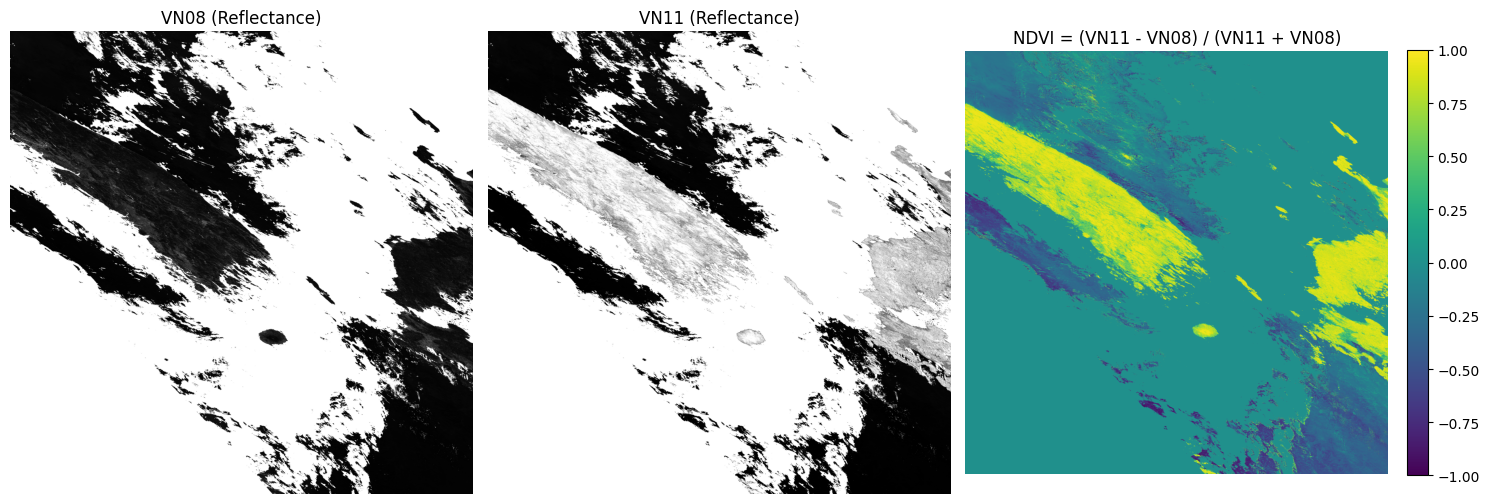

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def load_bin(path, shape=(4800, 4800), dtype=np.float32):
    with open(path, "rb") as f:
        arr = np.fromfile(f, dtype=dtype)
    return arr.reshape(*shape)

vn08_path = "data/Rs_VN08_reflectance_le_f32.bin"
vn11_path = "data/Rs_VN11_reflectance_le_f32.bin"

vn08 = load_bin(vn08_path)
vn11 = load_bin(vn11_path)

# NDVI (avoid divide-by-zero)
eps = 1e-10
ndvi = (vn11 - vn08) / (vn11 + vn08 + eps)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(vn08, vmin=0.0, vmax=0.4, cmap="gray")
axes[0].set_title("VN08 (Reflectance)")
axes[0].axis("off")

axes[1].imshow(vn11, vmin=0.0, vmax=0.4, cmap="gray")
axes[1].set_title("VN11 (Reflectance)")
axes[1].axis("off")

im = axes[2].imshow(ndvi, vmin=-1.0, vmax=1.0)  # default colormap
axes[2].set_title("NDVI = (VN11 - VN08) / (VN11 + VN08)")
axes[2].axis("off")
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

